In [17]:
#fastai library
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [ ]:
from fastbook import *
from fastai.vision.widgets import *
from fastai.vision.all import *
from google.colab import drive
drive.mount('/content/gdrive')

In [30]:
#경로
import os
attention_types = ['clap','default','nod','outOfFrame','smile','yawn']
path = Path('/content/gdrive/MyDrive/images')

#이미지 가져오기
fns = get_image_files(path)
#잘못된 이미지 확인
failed = verify_images(fns)
#잘못된 이미지 언링크
failed.map(Path.unlink)

(#0) []

In [40]:
#데이터블럭에서 검증셋의 비율을 말합니다.
valid_percent_value = 0.2
#데이터블럭에서의 시드를 말합니다
seed_value = 42
#바꿀 사이즈를 말합니다.
resize_value = 240
#이미지를 일부 잘라서 새로운 이미지를 생성할 때 최소한 남길 이미지의 비율을 말합니다. (0.5~0.8) 
#0.5  0.6  0.7 
min_scale_value = 0.6
#이미지를 왜곡하여 새로운 이미지를 생성할 때 얼마나 왜곡할 것인지에 대한 강도를 말합니다.
# 1.2  1.5
mult_value =1.5
#resnet 버전을 선택합니다.(가능한 값 : 18,34,50,101,152)
resnet_value = 50
#몇번 fit를 시킬지 정합니다
fit_value = 50
#학습률의 최댓값을 정합니다.
lr_value = 1e-5

In [ ]:
#cuda 에러 해결 코드
torch.cuda.empty_cache()

#데이터 블럭 생성
attention_datablock = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items = get_image_files,
    splitter =RandomSplitter(valid_pct=valid_percent_value,seed=seed_value),
    get_y = parent_label,
    item_tfms = Resize(resize_value)
)
#이미지 일부를 잘라낸 새로운 이미지를 생성
attention_datablock = attention_datablock.new(
    item_tfms=RandomResizedCrop(resize_value,min_scale=min_scale_value)
    )

#이미지를 왜곡하여 새로운 이미지를 생성
attention_datablock = attention_datablock.new(
    item_tfms = Resize(resize_value),batch_tfms=aug_transforms(mult=mult_value)
    )

#데이터로더 생성
dls_attention = attention_datablock.dataloaders(path)

#cnn 생성
learn = cnn_learner(dls_attention,resnet50,loss_func = CrossEntropyLossFlat(), metrics=error_rate)

#fit one cycle with lr_min
learn.fit_one_cycle(3, 1e-4)

learn.unfreeze()
#learn.lr_find()

learn.fit_one_cycle(fit_value, lr_max=slice(1e-5,1e-4))
#learn.fit_one_cycle(fit_value, lr_max=lr_value)

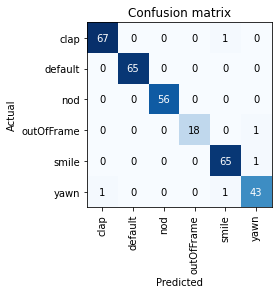

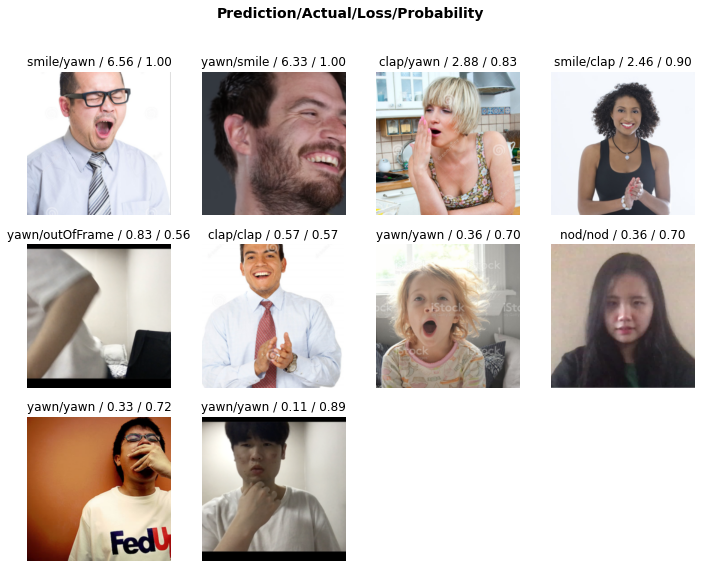

In [42]:
learn.export()

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(10)

In [ ]:
from fastai.vision.widgets import *

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

In [ ]:
img = PILImage.create(btn_upload.data[-1])
pred,pred_idx,probs = learn.predict(img)
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
btn_run = widgets.Button(description='Classify')
btn_run.on_click(on_click_classify)

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [ ]:
btn_upload = widgets.FileUpload()
VBox([widgets.Label('Select!'), 
      btn_upload, btn_run, out_pl, lbl_pred])